<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/clustering_consumers_by_lifetime_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this case study is to explore the Lifetimes library, created by Cameron Davidson-Pilon, in its application for the prediction and calculation of the Lifetime value for each consumer of a Brazilian E-commerce, for its subsequent segmentation in order to optimize of resources and commercial efforts for the company.

## What is the CLTV/CLV?

Better known as Customer Lifetime Value, this is a metric from the marketing world which, in short, reflects the profit that a certain customer will provide us in a given period of time. This allows us to get out of the subjectivism of how much a client is worth, and land that value in a more workable field related to the profitability that it brings to the company.

In [3]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 7.3 MB/s 


<center><img src="https://www.wearemarketing.com/uploads/media/default/0001/21/033ed59c7fa7a026804f9507fa7fc3a390390667.jpeg" width="800"></center>

### Why should we care it?

- It allows us to segment our clients according to their contributions.
- Identify patterns of behavior in our target audience.
- It enables better management of commercial investment for each consumer.
- Make an approximate prediction about future income to the company.
- Improve more personalized loyalty programs.

Therefore we can understand that improving the CLTV means increasing the amount of time in which this consumer is spending money in our company.

### What is its formula?

There are several ways to calculate this indicator, which vary by the periods of time with which one works or the expert who is dealing with the subject. But to facilitate its understanding we will use the most intuitive of them:

> CLTV = Average spending x  Frequency of purchase x Lifetime of client



## Briefing

Now that we have seen a little theory about this powerful metric and how its implementation can bring great benefits in the short and long term for our company, it is time to see the case that we will discuss today.

### Objective

Our main objective is to calculate the Lifetime Value per customer so that, based on them, segments can be created based on the profitability they bring to the company.

### Data information

The dataset we will work with was provided by Olist Store, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Therefore, our dataset contains a large number of purchases made between the 2016-2018 periods in different stores that used the Olist service.

- **Reliability:** High, the data is completely real and has been anonymized for the safety of the users.

- **Bias:** In advance, understand that the transactions belonging to different stores, with such varied items and segments, will not follow a standard pattern and the most probable is that they will not have a normal distribution. But to explore the subject and verify the scope of the Lifetimes library it will be quite useful.

- **License:** CC BY-NC-SA 4.0.

- **Repository:** Kaggle.

- **Link:** https://www.kaggle.com/olistbr/brazilian-ecommerce

Now that we have the data, our next step is to prepare it for analysis.

## Preprocess

### Importing libraries

In [4]:
!pip install lifetimes
import pandas as pd
import lifetimes
from datetime import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### First look to our datasets

Let's start with a first look at the data we have, in this case we will only use the Orders, Customer and Payments datasets. Since these three contain the variables that we will need to make use of the Lifetimes library and its models.

In [5]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [6]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom


We can see that in the Orders dataset we have a column called *order_status* which includes the current status of each order. We are only interested in working with the orders that have been concluded so far, so we must filter them.


We are left with a sample of 96,478 completed orders.

### Merging our data

Let's start with merging the three datasets into one from which we can extract the variables we need.

Here we have the final merge, but it is necessary to make a differentiation between the variables that we have: **order_id** clearly refers to the code of the order carried out, on the other hand we have **customer_id** which is the code assigned to the user by purchase (that is, the code varies from session to session, even if the person is the same) and finally **customer_unique_id** which actually reflects the user as a person, which is what we need to calculate their respective CLTV. Due to that we will proceed to eliminate the other two columns that do not serve us for the case.

We can see that our unique users are 93357, it is to each of them that we must calculate new variables. This is where an important point about the *Lifetimes* library comes in, and that is that to make use of its models it is necessary to present 4 specific variables called recency, frequency, T and monetary value. Do not worry, I will proceed to explain what each one of them is about:

- **Frequency:** Represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- **Recency:** Represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- **T:** Represents the age of the customer in whatever time units chosen. This is equal to the duration between a customer’s first purchase and the end of the period under study.
- **Monetary value:** Represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

Now that we know which variables we are going to use, if we see our created dataset again we have everything to calculate them, that will be our next step.

## Feature Engineering

Let's start by formatting our date variable and exploring its minimum (first purchase) and maximum (last purchase) values.

In [7]:
data["Total Amount"] = data["Quantity"]*data["Price"]
data['InvoiceDate'] = data.InvoiceDate.dt.date

In [9]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].describe()

count                  779428
unique                    604
top       2021-11-06 00:00:00
freq                     3340
first     2019-12-01 00:00:00
last      2021-12-09 00:00:00
Name: InvoiceDate, dtype: object

In [10]:
# The last purchase made in the dataset was on August 29, 2018, so we will use that date as our current 
# date to simulate an immediate study of the company's transactions.

today = '2021-12-09'
date_today = datetime.strptime(today, '%Y-%m-%d')

### Creating Recency

We will group by user in a new table.

In [11]:
r = data.groupby('CustomerID').agg(['min', 'max'])['InvoiceDate']
r['recency'] = r['max'] - r['min']

### Creating T
This same table helps us to create our variable T.

In [12]:
r['T'] = date_today - r['min']
r = r[['recency', 'T']]

# Let's take a look at our new variables
r

,recency,T
CustomerID,,
12346,401 days,726 days
12347,402 days,404 days
12348,363 days,438 days
12349,571 days,589 days
12350,0 days,310 days
...,...,...
18283,656 days,659 days
18284,0 days,431 days
18285,0 days,661 days


### Creating Frequency
As before we will group by unique user to create this variable.

In [14]:
aggregations = {
    'InvoiceDate':'count',
    'Total Amount': 'sum'}
f = data.groupby('CustomerID').agg(aggregations)
f['frequency'] = f['InvoiceDate'] - 1
f = f[['frequency']]

In [15]:
# Let's create our final table joining both

rf = pd.merge(r,f, left_index=True, right_index=True)
rf

,recency,T,frequency
CustomerID,,,
12346,401 days,726 days,33
12347,402 days,404 days,221
12348,363 days,438 days,50
12349,571 days,589 days,174
12350,0 days,310 days,16
...,...,...,...
18283,656 days,659 days,937
18284,0 days,431 days,27
18285,0 days,661 days,11


For our convenience, the *Lifetimes* library includes a module that takes care of this cumbersome process automatically. We will work with this table created by the library, since it includes the variable **monetary_value** and allows us to define the period of time with which we want to work (in our case we will choose weekly since our dataset belongs to different industries, this is a regular period of time).

In [17]:
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(data, customer_id_col='CustomerID', datetime_col='InvoiceDate', 
                                    monetary_value_col ='Total Amount', observation_period_end='2021-12-09', 
                                    datetime_format='%Y-%m-%d', freq='W')
rfm

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,7.0,58.0,104.0,11066.637143
12347,7.0,58.0,58.0,615.714286
12348,4.0,52.0,63.0,449.310000
12349,3.0,81.0,84.0,1120.056667
12350,0.0,0.0,44.0,0.000000
...,...,...,...,...
18283,18.0,94.0,94.0,142.666667
18284,0.0,0.0,62.0,0.000000
18285,0.0,0.0,94.0,0.000000


## Visualizing our customers

In [18]:
px.histogram(rfm, x=rfm['frequency'],title='Frequency of purchase',
                   labels={'frequency':'Frequency'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

Here we find an important point which can influence our model, the vast majority of buyers only made one transaction in their entire lifetime in the company (remember that frequency is calculated by subtracting the number of purchases minus 1).

In [19]:
px.histogram(rfm, x=rfm['recency'],title='Recency of purchase',
                   labels={'recency':'Recency'}, nbins=50,
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

As with the previous variable, most users have zero recency, having made only a single purchase in their time as a customer.

In [20]:
px.histogram(rfm, x=rfm['T'],title='Time from first purchase',
                   labels={'T':'Weeks'}, 
                   opacity=0.8, marginal='violin',
                   color_discrete_sequence=['indianred'])

In the case of the customer's lifetime in his last purchase, we can observe a distribution more similar to a Gaussian distribution, with 40 weeks as the mode. We can also observe a greater concentration in the left area, corroborating that most of them are sporadic purchases. Seeing this, let's move on to our first model.

## BetaGeoFitter

Also known as BG / NBD, this model is intended to estimate transactions in a future period of time for each user, in addition to the probability that this is "alive". This is an alternative to the well-known Pareto / NBD model which uses the Bayesian probability in a hierarchical way to make its estimates. Its main difference with Pareto is that BG assumes that customer abandonment occurs immediately after the purchase of the product, while its alternate assumes that abandonment can occur at any time. Without delving further into theory, let's move on to its application in our data set.

http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

In [21]:
from lifetimes import BetaGeoFitter

# penalizer_coef es un parámetro que penaliza al likelihood, usualmente se utilizan valores como 0.001 o 
# 0.01 con muestras pequeñas para evitar que los parámetros se vuelvan demasiado grandes

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'], verbose=True)
print(bgf)

Optimization terminated successfully.
         Current function value: -5.781217
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
<lifetimes.BetaGeoFitter: fitted with 5878 subjects, a: 0.06, alpha: 10.51, b: 1.18, r: 0.72>


In [22]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.715728,0.017564,0.681303,0.750153
alpha,10.505332,0.324168,9.869963,11.140701
a,0.064158,0.007186,0.050072,0.078243
b,1.177305,0.153793,0.875871,1.478738


We have already trained our model, we can make greater use of the library with the following visualizations.

**Frequency recency matrix:** This matrix shows us the probability of future customer purchases in a given time, using recency and frequency as estimators.

**Probability alive matrix:** Like the previous one, using recency and frequency as indicators, this matrix indicates the probability that a client is "alive" at the current moment.

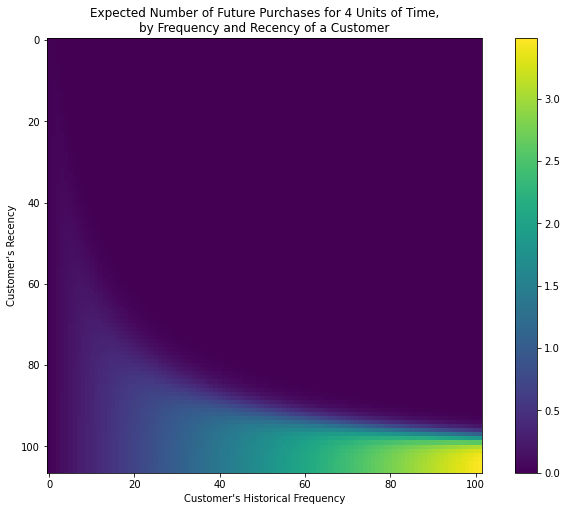

In [23]:
from lifetimes.plotting import plot_frequency_recency_matrix

# T = Unit times(weeks)

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf, T=4)

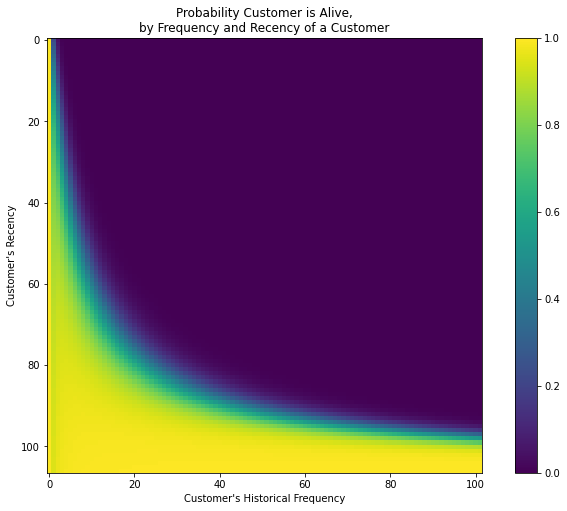

In [24]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

As we can see, both probabilities increase the greater the number of purchases and the time the customer had on his last purchase. It should be noted that the probabilities of future purchases are quite low in the next four weeks and are restricted to a few customer quadrants, this can be easily explained by the trend in sporadic purchases in our dataset.

Based on our model we can create predictions for the period of time we choose, in our case we will do it for the first 4, 8 and 12 weeks, these being a strong short-term indicator to increase our advertising efforts in users with the greatest possibility of invest in our company.

In [25]:
t = 4 # Weeks for a future transaction 
rfm['expected_4week'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm['frequency'], rfm['recency'], rfm['T']), 2)
rfm.sort_values(by='expected_4week', ascending=False)

,frequency,recency,T,monetary_value,expected_4week
CustomerID,,,,,
14606,101.0,105.0,105.0,289.483564,3.52
17841,101.0,105.0,105.0,665.993168,3.52
15311,97.0,106.0,106.0,1176.736082,3.35
14911,94.0,106.0,106.0,3092.416809,3.25
14527,90.0,105.0,105.0,277.068000,3.14
...,...,...,...,...,...
14160,6.0,13.0,100.0,794.515000,0.00
15015,9.0,32.0,104.0,247.263333,0.00
15633,12.0,32.0,105.0,345.339167,0.00


In [26]:
rfm['expected_8week'] = round(bgf.predict(8, rfm['frequency'], rfm['recency'], rfm['T']), 2)
rfm['expected_12week'] = round(bgf.predict(12, rfm['frequency'], rfm['recency'], rfm['T']), 2)

In turn, we can have more molecular analyzes, by seeing the individual probabilities for each client:

In [38]:
t=12
#random_person = rfm.iloc[[0,65432]]
prediction = bgf.predict(t, rfm['frequency'], rfm['recency'], rfm['T'])

#print("Customer '{}' has ".format(random_person.name), round(prediction, 2), "% of probability to buy an item for the next {} weeks".format(t))

## Validating our model

Well we have our predictions, but we cannot blindly use the results of a model, we need to validate them with reality. When we talk about making predictions for the future, instead of doing the classic partition of the sample in Train and Test, we do it with respect to time. We will use the last three months of results whose numbers we already know and compare them with what we obtain with our BG/NBD model, for this task the *Lifetimes* library has a very useful function that divides our data set according to the indicated date.


In [42]:
from lifetimes.utils import calibration_and_holdout_data

rfm_val = calibration_and_holdout_data(data, customer_id_col='CustomerID', datetime_col='InvoiceDate', 
                                    monetary_value_col ='Total Amount', calibration_period_end='2021-05-29',
                                    observation_period_end='2021-12-09', datetime_format='%Y-%m-%d', freq='W')


rfm_val.head(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,7.0,58.0,76.0,11066.637143,0.0,0.000000,28.0
12347,3.0,23.0,30.0,607.810000,4.0,25.373163,28.0
12348,3.0,28.0,35.0,495.746667,1.0,103.333333,28.0
12349,2.0,26.0,56.0,801.310000,1.0,24.076027,28.0
12350,0.0,0.0,16.0,0.000000,0.0,0.000000,28.0


Our metrics are divided into *cal* and *holdout*, the first being those used in training and the second being the result in the two months that we established, while duration refers to the time in weeks that was taken for the test. Now it is time to train this new table with the same model that we configured previously.

In [43]:
bgf_val = BetaGeoFitter(penalizer_coef=0.001)
bgf_val.fit(rfm_val['frequency_cal'], rfm_val['recency_cal'], rfm_val['T_cal'], verbose=True)
print(bgf_val)

Optimization terminated successfully.
         Current function value: -3.509595
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
<lifetimes.BetaGeoFitter: fitted with 4930 subjects, a: 0.06, alpha: 11.33, b: 1.10, r: 0.75>


Our first validation visualization shows the comparison between the frequency of real transactions and those established by the new model. We can see that as frequencies increase, the model performs a worse job of predicting, this may be due to the great heterogeneity of e-commerce as mentioned above or to the lack of a sufficient sample to establish reliable estimates.
- It should be noted that a logarithmic scaling is carried out to be able to visualize the high frequencies, since compared to frequency 0 their heights are very small.

<Figure size 864x576 with 0 Axes>

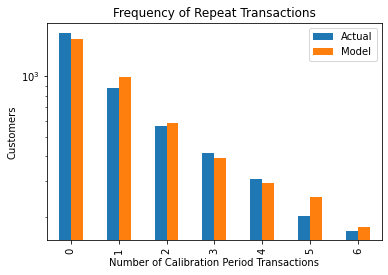

In [44]:
from lifetimes.plotting import plot_period_transactions

fig = plt.figure(figsize=(12,8))
ax = plot_period_transactions(bgf_val)
ax.set_yscale('log')

Our second visualization will give us a more accurate understanding of the effectiveness of our model estimates, when comparing actual purchases versus predictions.

<Figure size 864x576 with 0 Axes>

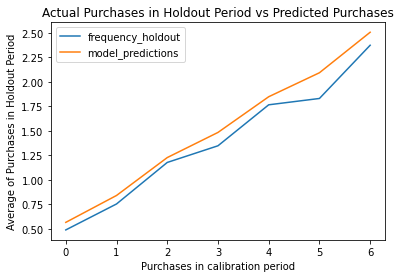

In [45]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

fig = plt.figure(figsize=(12,8))
plot_calibration_purchases_vs_holdout_purchases(model=bgf_val, calibration_holdout_matrix=rfm_val)

In this last graph we can see how the model starts making predictions quite close to the margin of error, said distance increases as the number of purchases increases until it shoots up violently, this is most likely due to some anomalous data that the model did not reach to take into account. In any case, our model maintains a coherent exponential growth and is similar in some points to the reality of the business. Extending the time that is taken for the test could improve the validation of our model.

## Gamma-Gamma model

We have predictions for our next few months but we do not know exactly what will be the remuneration that we will obtain from our clients, a client who buys 13 times an average of 7 dollars is not the same as another who buys 2 times 300 dollars. This is when the second model in this case will help us to give an estimate of the profitability of each client, using the *monetary_value* column which we had left until now.


We begin first of all with the fact that one of the requirements of this model is to work only with observations with a purchase frequency greater than 0, we see that our sample is considerably reduced to 1918 subjects who are still well to be able to train a model of this type.

In [46]:
rfm_gg = rfm[rfm['frequency'] > 0]
len(rfm_gg)

4172

On the other hand, we need to make sure that there is no correlation between the frequency of purchase and the monetary value of each consumer. This is due to the fact that the Gamma-Gamma model assumes that there is no such correlation. In practice, check if the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [47]:
rfm_gg[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.034331
frequency,0.034331,1.000000


In [48]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(rfm_gg['frequency'], rfm_gg['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4172 subjects, p: 2.30, q: 3.42, v: 432.70>


One of the faculties of this model is to calculate the conditional expectation for the average profit per transaction for a group of one or more customers.

In [49]:
rfm['avg_transaction'] = round(ggf.conditional_expected_average_profit(rfm_gg['frequency'],
                                                     rfm_gg['monetary_value']), 2)

rfm['avg_transaction'] = rfm['avg_transaction'].fillna(0)
rfm.sort_values(by='avg_transaction', ascending=False)

,frequency,recency,T,monetary_value,expected_4week,expected_8week,expected_12week,avg_transaction
CustomerID,,,,,,,,
16446,1.0,29.0,29.0,168469.600000,0.16,0.33,0.49,82288.71
18102,53.0,106.0,106.0,10918.883019,1.84,3.68,5.51,10714.27
15749,1.0,13.0,47.0,21535.900000,0.10,0.19,0.28,10703.04
12346,7.0,58.0,104.0,11066.637143,0.18,0.37,0.55,9673.84
14646,60.0,105.0,105.0,8713.122167,2.10,4.19,6.28,8569.99
...,...,...,...,...,...,...,...,...
17079,0.0,0.0,11.0,0.000000,0.13,0.26,0.39,0.00
17078,0.0,0.0,5.0,0.000000,0.18,0.36,0.54,0.00
17077,0.0,0.0,83.0,0.000000,0.03,0.06,0.09,0.00


The column that we have just created gives us the approximate amount that the customer will make in a future purchase, but if we review well we will find that this metric does not really tell us anything by itself, because customers with the highest number of transaction are unlikely to buy in the following periods. In summary, this new indicator is conditioned on the assumption that a purchase is actually made.

To find the value we are looking for, and which is found in the title of this article, we will use another module of this model which uses the model we created previously to estimate the CLV of each client in the period we choose. For our reality we will use an estimate of the next 26 weeks (6 months) to calculate the Lifetime Value.
- *discount_rate* refers to external factors that may influence the company's income, such as currency inflation, new company taxes, among others.

In [50]:
rfm['CLV'] = round(ggf.customer_lifetime_value(bgf, rfm['frequency'],
                    rfm['recency'], rfm['T'], rfm['monetary_value'],
                    time=26, discount_rate=0.01, freq='W'))

rfm.sort_values(by='CLV', ascending=False)

,frequency,recency,T,monetary_value,expected_4week,expected_8week,expected_12week,avg_transaction,CLV
CustomerID,,,,,,,,,
18102,53.0,106.0,106.0,10918.883019,1.84,3.68,5.51,10714.27,477408.0
14646,60.0,105.0,105.0,8713.122167,2.10,4.19,6.28,8569.99,435362.0
16446,1.0,29.0,29.0,168469.600000,0.16,0.33,0.49,82288.71,316730.0
17450,26.0,62.0,63.0,7905.648077,1.45,2.89,4.32,7614.05,264140.0
14156,75.0,105.0,106.0,4164.944267,2.59,5.18,7.76,4112.99,258227.0
...,...,...,...,...,...,...,...,...,...
17448,10.0,21.0,92.0,1344.273000,0.00,0.00,0.00,1255.40,6.0
18051,6.0,13.0,104.0,324.830000,0.00,0.00,0.00,337.70,4.0
14590,16.0,44.0,105.0,180.310625,0.00,0.00,0.00,194.56,2.0


Now that we have our final variable, we will move on to the last step of this case, the clustering of our consumers based on the profitability provided to the company. For this we can already eliminate our initial variables that we use to build the models.

In [51]:
clusters = rfm.drop(rfm.iloc[:, 0:4], axis=1)

## Clustering our forecasts

We have four variables to be able to carry out our segmentation, for this we will use an unsupervised Machine Learning method already known to many, K-Means. To make use of it, it is necessary to normalize our variables, since as this is a model that works with the distances of the data, the dimensions and magnitudes play a very important role in its implementation.

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(clusters)
scaled

array([[-0.19157179, -0.17245921, -0.17677225,  8.08474315,  3.06285977],
       [ 0.72966543,  0.71646476,  0.71368073,  0.23706997,  0.25634913],
       [ 0.04726749,  0.04977179,  0.04013296,  0.10955318, -0.02457064],
       ...,
       [-0.70337024, -0.71948934, -0.71332725, -0.27169285, -0.2050687 ],
       [-0.63513044, -0.63401588, -0.64483087,  0.26117913, -0.17113414],
       [ 0.0131476 ,  0.0155824 ,  0.0287169 ,  0.23411571,  0.03654227]])

When choosing the number of clusters to create, it is advisable to discuss it with the department involved and set a number that responds to the nature of the business and the needs of the problem. But in our case we will use the famous "Elbow Method" that will indicate the number of clusters that reduces the inertia (closeness of the points to their centroid) to a relevant point.

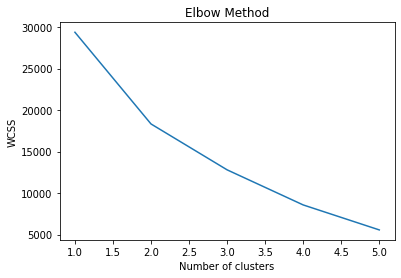

In [53]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=0)
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

I consider that the number three is the most appropriate for our segmentation, due to being a symbolically very powerful number in time and of course this is the result of our graph. With this number of clusters we can now train our model with the scaled database and attach the created labels to our initial table.

In [54]:
model = KMeans(n_clusters = 3, max_iter = 1000)
model.fit(scaled)
labels = model.labels_

In [55]:
clusters['cluster'] = labels
clusters['cluster'].value_counts()

1    5258
0     613
2       7
Name: cluster, dtype: int64

At first glance, we see that our cluster "0" makes a clear reference to the entire group of sporadic shopping users that represented the vast majority of our e-commerce. We can get a better visualization of these new segments by using PCA to reduce our variables to two and be able to translate them into a scatter plot.

In [56]:
from sklearn.decomposition import PCA

features = ["expected_4week", "expected_8week", "expected_12week", "avg_transaction", "CLV"]

pca = PCA(n_components=2)
components = pca.fit_transform(clusters[features])
npc = np.array(components)
dfc = pd.DataFrame(npc, columns=['PC1','PC2'])
dfc = dfc.set_index(clusters.index)
dfc['label'] = clusters['cluster']
dfc

,PC1,PC2,label
CustomerID,,,
12346,40294.633268,7447.670073,1
12347,3348.250373,115.025353,1
12348,-313.627421,141.930465,1
12349,546.987677,596.006637,1
12350,-2446.257024,-198.182502,1
...,...,...,...
18283,-235.257778,-145.981338,0
18284,-2568.118436,-192.368996,1
18285,-2682.987799,-186.889051,1


In [57]:
px.scatter(dfc, x="PC1", y="PC2", color="label")

We saw that the K-Means model did a good job clustering our users, but my intuition together with the result of the graph and the number of users per cluster tell me that the order of the clusters does not really represent the importance of the client with respect to the cost effectiveness. Let's corroborate this mini theory by looking at the maximums and minimums of each cluster.

In [58]:
clusters.groupby('cluster').agg(['max','min'])['CLV']

,max,min
cluster,,
0,160325.0,1818.0
1,42835.0,0.0
2,477408.0,237764.0


Indeed, group 1 represents the group with the highest profitability, while group 2 represents the group with moderate profitability. Let's finish our final table by assigning the corresponding names to each segment.

In [59]:
clusters['cluster'].replace(to_replace=[0,1,2], value = ['Non-Profitable', 'Very Profitable', 'Profitable'], inplace=True)
clusters.sort_values(by='CLV', ascending=False)

,expected_4week,expected_8week,expected_12week,avg_transaction,CLV,cluster
CustomerID,,,,,,
18102,1.84,3.68,5.51,10714.27,477408.0,Profitable
14646,2.10,4.19,6.28,8569.99,435362.0,Profitable
16446,0.16,0.33,0.49,82288.71,316730.0,Profitable
17450,1.45,2.89,4.32,7614.05,264140.0,Profitable
14156,2.59,5.18,7.76,4112.99,258227.0,Profitable
...,...,...,...,...,...,...
17448,0.00,0.00,0.00,1255.40,6.0,Very Profitable
18051,0.00,0.00,0.00,337.70,4.0,Very Profitable
14590,0.00,0.00,0.00,194.56,2.0,Very Profitable


We begin our case study with a typical relational database of various E-Commerce, ending with a segmentation of each of its users regarding their probability of future purchase and the profitability of the company. The *Lifetimes* package is a very powerful package, although at the beginning it feels like a black box, the study and understanding of each of its functions together with the validation of its models, makes it an ally for all that company with the intention to know your consumers better and optimize your investment in each area of contact with the customer. I hope you reader have enjoyed this case and it has been "profitable" for a better understanding of both the library and the application capacity it brings to the business.

## Recomendations

- A better performance of each model should be given with the application in more homogeneous databases referring to each company.
- The use of more specific variables at the time of clustering can give more precise and enriching results for the area to which the study is intended.
- *Lifetimes* has other models based on Bayesian probability, each with its own advantages and particular applications. Studying them and seeing if they fit the case at hand could yield better results.
